## General information

Two Sigma Financial News Competition is a unique competitions: not only it is a Kernel-only competition, but we aren't supposed to download data and during stage two our solutions will be used to predict future real data.

I'll try to do an extensive EDA for this competition and try to find some interesting things about the data.

P. S. I'l learning to use plotly, so there will be interactive charts at last!

### Getting data and importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [3]:
mkt_url = 'raw/market.csv'
news_url = 'raw/newsdata.csv'

market_dtypes = {
    'assetCode': str,
    'assetName': str,
    'volume': float,
    'close': float,
    'open': float,
    'returnsClosePrevRaw1': float,
    'returnsOpenPrevRaw1': float,
    'returnsClosePrevMktres1': float,
    'returnsOpenPrevMktres1': float,
    'returnsClosePrevRaw10': float,
    'returnsOpenPrevRaw10': float,
    'returnsClosePrevMktres10': float,
    'returnsOpenPrevMktres10': float,
    'returnsOpenNextMktres10': float,
    'universe': float
}
market_date_cols = ['time']

news_dtypes = {
    'sourceId': str,
    'headline': str,
    'urgency': int,
    'takeSequence': int,
    'provider': str,
    'subjects': str,
    'audiences': str,
    'bodySize': int,
    'companyCount': int,
    'headlineTag': str,
    'marketCommentary': bool,
    'sentenceCount': int,
    'wordCount': int,
    'assetCodes': str,
    'assetName': str,
    'firstMentionSentence': int,
    'relevance': float,
    'sentimentClass': int,
    'sentimentNegative': float,
    'sentimentNeutral': float,
    'sentimentPositive': float,
    'sentimentWordCount': int,
    'noveltyCount12H': int,
    'noveltyCount24H': int,
    'noveltyCount3D': int,
    'noveltyCount5D': int,
    'noveltyCount7D': int,
    'volumeCounts12H': int,
    'volumeCounts24H': int,
    'volumeCounts3D': int,
    'volumeCounts5D': int,
    'volumeCounts7D': int}
news_date_cols = ['time', 'sourceTimestamp', 'firstCreated', ]

market_df = pd.read_csv(mkt_url, dtype=market_dtypes, parse_dates=market_date_cols)
news_df = pd.read_csv(news_url, dtype=news_dtypes, parse_dates=news_date_cols)

train_range = (datetime.date(2014,1,1), datetime.date(2015,12,31))
test_range = (datetime.date(2016,1,1), datetime.date(2016,12,31))

market_train_df = market_df.loc[(market_df['time'].dt.date >= train_range[0]) & (market_df['time'].dt.date <= train_range[1])]
market_test_df = market_df.loc[(market_df['time'].dt.date >= test_range[0]) & (market_df['time'].dt.date <= test_range[1])]

news_train_df = news_df.loc[(news_df['time'].dt.date >= train_range[0]) & (news_df['time'].dt.date <= train_range[1])]
news_test_df = news_df.loc[(news_df['time'].dt.date >= test_range[0]) & (news_df['time'].dt.date <= test_range[1])]

del market_df
del news_df

In [4]:
market_train_df.shape, news_train_df.shape, market_test_df.shape, news_test_df.shape

((835150, 16), (2133320, 35), (458863, 16), (949486, 35))

We have two datasets, let's explore them separately.

## Market data

We have a really interesting dataset which contains stock prices for many companies over a decade!

For now let's have a look at the data itself and not think about the competition. We can see long-term trends, appearing and declining companies and many other things.

In [5]:
print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

835150 samples and 16 features in the training market dataset.


In [6]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
2778943,2014-01-02 22:00:00+00:00,A.N,Agilent Technologies Inc,1916160.0,56.21,57.10,-0.017136,-0.006092,-0.007543,-0.007686,-0.000542,0.022721,-0.006178,0.012864,0.080747,1.0
2778944,2014-01-02 22:00:00+00:00,AAL.O,American Airlines Group Inc,8998943.0,25.36,25.07,0.004356,0.013339,0.004133,0.013458,-0.028352,-0.052890,0.008661,-0.002467,0.175047,1.0
2778945,2014-01-02 22:00:00+00:00,AAN.N,Aaron's Inc,865111.0,29.45,29.43,0.001701,0.003067,0.002466,0.003173,0.017271,0.022230,-0.002462,-0.004037,-0.112403,1.0
2778946,2014-01-02 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,542711.0,109.74,110.36,-0.008493,0.005100,-0.006339,0.005726,0.012362,0.007216,0.044818,0.052303,0.065097,1.0
2778947,2014-01-02 22:00:00+00:00,AAPL.O,Apple Inc,8398851.0,553.13,555.68,-0.014064,0.002725,-0.012363,0.001978,-0.003351,-0.000234,0.020071,0.027940,-0.007432,1.0


At first let's take 10 random assets and plot them.

In [7]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

I plot data for all periods because I'd like to show long-term trends.
Assets are sampled randomly, but you should see that some companies' stocks started trading later, some dissappeared. Disappearence could be due to bankruptcy, acquisition or other reasons.

Well, these were some random companies. But it would be more interesting to see general trends of prices.

In [8]:
data = []
#market_train_df['close'] = market_train_df['close'] / 20
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

It is cool to be able to see how markets fall and rise again.
I have shown 4 events when there were serious stock price drops on the market.
You could also notice that higher quantile prices have increased with time and lower quantile prices decreased.
Maybe the gap between poor and rich increases... on the other hand maybe more "little" companies are ready to go to market and prices of their shares isn't very high.

Now, let's look at these price drops in details.

In [9]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [10]:
print(f"Average standard deviation of price change within a day in {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day in 1.0196.


In [11]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

We can see huge price fluctiations when market crashed. Just think about it... **But this is wrong!** There was no huge crash on January 2010... Let's dive into the data!

### Possible data errors

At first let's simply sort data by the difference between open and close prices.

In [12]:
market_train_df.sort_values('price_diff')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.590,263.80,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,0.0,-207.210
3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.190,612.00,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,0.0,-75.810
3029223,2014-08-12 22:00:00+00:00,ICPT.O,Intercept Pharmaceuticals Inc,6088050.0,276.520,345.62,0.165866,0.443150,0.169396,0.438971,0.181003,0.532683,0.156578,0.480568,0.023082,0.0,-69.100
2884208,2014-04-04 22:00:00+00:00,PCLN.O,Priceline Group Inc,2042352.0,1178.080,1245.35,-0.047978,-0.015534,-0.013328,-0.013725,-0.071526,-0.054397,-0.069304,-0.078940,0.046705,1.0,-67.270
2861065,2014-03-17 22:00:00+00:00,ICPT.O,Intercept Pharmaceuticals Inc,2199088.0,407.160,463.91,-0.119197,-0.023553,-0.117158,-0.024120,-0.016735,0.149772,-0.035284,0.164542,-0.256098,0.0,-56.750
2907020,2014-04-25 22:00:00+00:00,PCLN.O,Priceline Group Inc,1396417.0,1157.240,1212.00,-0.049128,-0.016234,-0.027687,-0.010588,-0.017039,-0.016010,-0.033384,-0.019842,-0.020692,1.0,-54.760
2890712,2014-04-10 22:00:00+00:00,PCLN.O,Priceline Group Inc,1559097.0,1177.300,1231.72,-0.046435,0.028696,0.005836,-0.001496,-0.004187,0.036130,0.009354,0.014862,-0.023611,1.0,-54.420
3550134,2015-11-09 22:00:00+00:00,PCLN.O,Priceline Group Inc,2652401.0,1311.150,1362.30,-0.095696,-0.061389,-0.084453,-0.061245,-0.074256,-0.009236,-0.079577,-0.021173,-0.055919,1.0,-51.150
3417483,2015-07-24 22:00:00+00:00,AMZN.O,Amazon.com Inc,21909381.0,529.420,578.99,0.097972,0.177623,0.104858,0.177598,0.193705,0.314423,0.190349,0.247775,-0.000311,1.0,-49.570
2867957,2014-03-21 22:00:00+00:00,PCLN.O,Priceline Group Inc,1170670.0,1268.835,1316.99,-0.018226,0.024361,-0.013895,0.010178,-0.065687,-0.040479,-0.036617,-0.031465,-0.079143,1.0,-48.155


So price of "Towers Watson & Co" shares was almost 10k... I think this is simply an error in data.

But what about Bank of New York Mellon Corp?

Let's see data by Yahoo:

![](https://i.imgur.com/C3COWfe.png)

There were no spikes.

Another case is with cost equal to 999, such numbers are usually suspicious. Let's look at Archrock Inc - no spikes there as well.

![](https://i.imgur.com/KYZKkSd.png)

So, let's try to find strange cases.

In [13]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [14]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 61 lines price increased by 20% or more.
In 48 lines price decreased by 20% or more.


Well, this isn't much considering we have more than 4 million lines and a lot of these cases are due to price falls during market crash. Well just need to deal with outliers.

In [15]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 0 lines price increased by 100% or more.
In 1 lines price decreased by 100% or more.


In [40]:
# market_train_df.shape
# market_train_df.loc[market_train_df['close_to_open'] <= 0.5]
# market_train_df.iloc[100000]

time                        2014-04-01 22:00:00+00:00
assetCode                                      HSIC.O
assetName                            Henry Schein Inc
volume                                         434551
close                                          119.92
open                                           119.57
returnsClosePrevRaw1                       0.00460752
returnsOpenPrevRaw1                         0.0100524
returnsClosePrevMktres1                   -0.00117581
returnsOpenPrevMktres1                     0.00445608
returnsClosePrevRaw10                      0.00612467
returnsOpenPrevRaw10                       0.00327236
returnsClosePrevMktres10                  -0.00148911
returnsOpenPrevMktres10                   -0.00447058
returnsOpenNextMktres10                    -0.0162891
universe                                            0
price_diff                                       0.35
close_to_open                                 1.00293
assetName_mean_open         

For a quick fix I'll replace outliers in these lines with mean open or close price of this company.

In [42]:
# TODO: fix with df.apply()
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    print('**********************', i)
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

Now let's try to build that graph again.

In [43]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now the graph is much more reasonable.

Now let's take a look at out target variable.

In [44]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

We can see that quantiles have a high deviation, but mean value doesn't change much.

Now I think it is time to throw an old part of dataset. Let's leave only data since 2010 year, this way we will get rid of the data of the biggest crisis.

Let's look at the target variable now.

In [45]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Treand of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Fluctuations seem to be high, but in fact they are lower that 8 percent. In fact it looks like a random noise...

Now let's remember the description:
```
The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

    Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
    Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
    Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
    Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.
```

Let's have a look at means of these variables.

In [46]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Well, for me it is difficult to interpret this, but it seems that returns for previous 10 days fluctuate the most.

### News data

In [47]:
news_train_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
6217411,2014-01-01 00:18:00+00:00,2014-01-01 00:18:00+00:00,2014-01-01 00:18:00+00:00,38d266baaa40e442,Campbell Recalls 300 Cases of Prego® Tradition...,3,1,BSW,"{'NCYC', 'AMERS', 'FOTB', 'ENT', 'FDRT', 'US',...","{'CNR', 'BSW'}",...,0,0,0,0,0,0,0,0,0,2
6217412,2014-01-01 00:28:22+00:00,2014-01-01 00:28:22+00:00,2014-01-01 00:28:22+00:00,6042bf4938aad77c,Walmart to Provide Prescriptions at No Upfront...,3,1,PRN,"{'AMERS', 'US', 'CMPNY', 'LEN', 'NEWR', 'SHOP'...","{'CNR', 'PRN'}",...,0,0,0,0,0,1,3,3,8,20
6217413,2014-01-01 00:31:26+00:00,2014-01-01 00:31:26+00:00,2014-01-01 00:31:26+00:00,babd163403e0258c,WAL-MART STORES INC <WMT.N> SAYS WILL PROVIDE ...,1,1,RTRS,"{'AMERS', 'US', 'CMPNY', 'GEN', 'LEN', 'HEA', ...","{'C', 'U', 'ELN', 'GRO', 'D', 'M', 'MNI', 'OIL...",...,0,0,0,0,0,2,4,4,9,21
6217414,2014-01-01 00:31:57+00:00,2014-01-01 00:31:57+00:00,2014-01-01 00:31:26+00:00,3ec1cb25f11e16c2,WAL-MART MOVE COMES DAY AFTER WALGREEN CO <WAG...,1,2,RTRS,"{'AMERS', 'US', 'CMPNY', 'GEN', 'LEN', 'HEA', ...","{'C', 'U', 'ELN', 'GRO', 'D', 'M', 'MNI', 'OIL...",...,0,0,0,0,0,3,5,5,10,22
6217415,2014-01-01 00:45:51+00:00,2014-01-01 00:45:51+00:00,2014-01-01 00:31:26+00:00,bf386aedd46d32e5,Wal-Mart offers 30 days of prescriptions to ba...,3,1,RTRS,"{'BANK', 'SHOP', 'SOCI', 'POL', 'US', 'GEN', '...","{'C', 'U', 'ELN', 'GRO', 'D', 'M', 'MNI', 'OIL...",...,2,2,2,2,2,4,6,6,11,23


In [48]:
print(f'{news_train_df.shape[0]} samples and {news_train_df.shape[1]} features in the training news dataset.')

2133320 samples and 35 features in the training news dataset.


The file is too huge to work with text directly, so let's see a wordcloud of the last 100000 headlines.

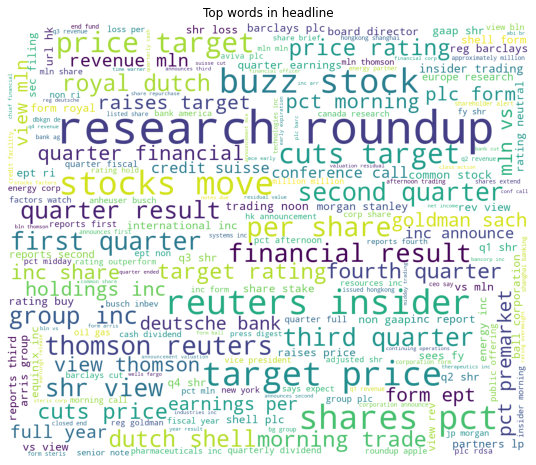

In [49]:
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [ ]:
# Let's also limit the time period
# news_train_df = news_train_df.loc[news_train_df['time'] >= '2010-01-01 22:00:00+0000']

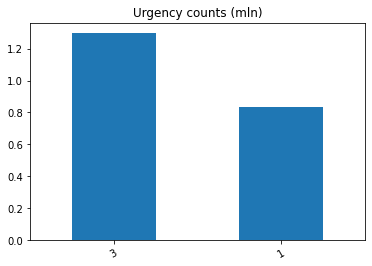

In [50]:
(news_train_df['urgency'].value_counts() / 1000000).plot(kind='bar');
plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

Well, it seems that in fact urgency "2" is almost never used.

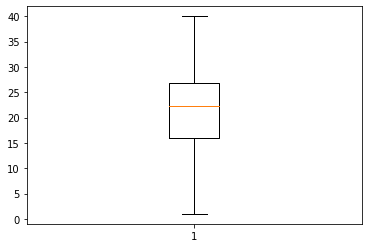

In [51]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']
plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40]);

There are some big outliers, but sentences mostly have 15-25 words in them.

In [52]:
news_train_df['provider'].value_counts().head(10)

RTRS    1632139
PRN      164669
BSW      143289
GNW       52127
LSE       43277
MKW       37144
HIIS      29569
ONE       10043
CNW        9063
RNS        6939
Name: provider, dtype: int64

It isn't surprising that Reuters is the most common provider :)

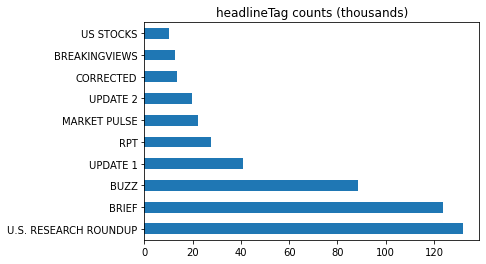

In [53]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot(kind='barh');
plt.title('headlineTag counts (thousands)');

Well, most news are tagless.

In [54]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Apple Inc                  4945
General Motors Co          4543
JPMorgan Chase & Co        4440
Latam Airlines Group SA    4016
Citigroup Inc              3999
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
HSBC Holdings PLC        9927
Credit Suisse AG         9908
Deutsche Bank AG         5101
Barclays PLC             4857
Royal Dutch Shell PLC    3671
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Royal Dutch Shell PLC    8169
Barclays PLC             5373
Apple Inc                5115
Steris Corp              4501
Shire PLC                4479
Name: assetName, dtype: int64



I think it is quite funny that Apple is a company with most both negative and positive sentiments.

At first I was sad that we don't have access to the texts of the news, but I have realized that we won't be able to use them anyway due to kernel memory limitations.

## Modelling

It's time to build a model!
I think that in this case we should build a binary classifier - we will simply predict whether the target goes up or down.

In [66]:
#%%time
# code mostly takes from this kernel: https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-xgb

def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume']
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean()
    news_df['sentence_word_count'] =  news_df['wordCount'] / news_df['sentenceCount']
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0)
    
    return market_df

market_train_df.drop(['price_diff', 'assetName_mean_open', 'assetName_mean_close'], axis=1, inplace=True)
market_train = data_prep(market_train_df, news_train_df)
print(market_train.shape)
up = market_train.returnsOpenNextMktres10 >= 0

fcol = [c for c in market_train.columns if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'assetCodeT',
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider',
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train[fcol].values
up = up.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

(179621, 54)


/home/lqin/github/news_alpha/.env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

invalid value encountered in subtract

/home/lqin/github/news_alpha/.env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

invalid value encountered in true_divide



In [67]:
X_train, X_test, up_train, up_test, r_train, r_test = model_selection.train_test_split(X, up, r, test_size=0.1, random_state=99)

# xgb_up = XGBClassifier(n_jobs=4,
#                        n_estimators=300,
#                        max_depth=3,
#                        eta=0.15,
#                        random_state=42)

In [68]:
params = {'learning_rate': 0.01, 'max_depth': 12, 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'is_training_metric': True, 'seed': 42}
model = lgb.train(params, train_set=lgb.Dataset(X_train, label=up_train), num_boost_round=2000,
                  valid_sets=[lgb.Dataset(X_train, label=up_train), lgb.Dataset(X_test, label=up_test)],
                  verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.585572	valid_1's auc: 0.56768
[200]	valid_0's auc: 0.59336	valid_1's auc: 0.569012
[300]	valid_0's auc: 0.600931	valid_1's auc: 0.571309
[400]	valid_0's auc: 0.607971	valid_1's auc: 0.572186
[500]	valid_0's auc: 0.614762	valid_1's auc: 0.572696
[600]	valid_0's auc: 0.621272	valid_1's auc: 0.573184
[700]	valid_0's auc: 0.627466	valid_1's auc: 0.573469
[800]	valid_0's auc: 0.633364	valid_1's auc: 0.573936
[900]	valid_0's auc: 0.639038	valid_1's auc: 0.574345
[1000]	valid_0's auc: 0.644744	valid_1's auc: 0.574629
[1100]	valid_0's auc: 0.650027	valid_1's auc: 0.574822
[1200]	valid_0's auc: 0.655368	valid_1's auc: 0.57515
[1300]	valid_0's auc: 0.660369	valid_1's auc: 0.575371
[1400]	valid_0's auc: 0.66524	valid_1's auc: 0.575609
[1500]	valid_0's auc: 0.669947	valid_1's auc: 0.575895
[1600]	valid_0's auc: 0.674818	valid_1's auc: 0.576147
[1700]	valid_0's auc: 0.679368	valid_1's auc: 0.576385
[1800]	valid_0's

In [69]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': model.feature_importance(), 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())

    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of LGB',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

In [33]:
days = env.get_prediction_days()
import time

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')
    
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = model.predict(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2 * lp -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in true_divide



50 100 150 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in subtract



200 250 300 350 400 450 500 550 600 Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
